# INM702: Task 1

This task is about classifying images of written numbers from the MNIST dataset. We develop a neural network using basic libraries such as NumPy, without resorting to ready-made functions from TensorFlow, Keras or PyTorch.

The work presented here is part of the coursework of the INM702 module at City, University of London. The Github repository can be found [here](https://github.com/yasirbarlas/City-INM702).

### Import Libraries and Load MNIST

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Ignore warnings (making the work easier to read)
import warnings
warnings.filterwarnings("ignore")

# Use TensorFlow to load MNIST (easy method)
import tensorflow.keras.datasets.mnist as mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [2]:
# Length * Width
image_pixels = X_train.shape[1] * X_train.shape[1]

# Convert training and test sets to 2-D arrays, and normalise
X_train = X_train.reshape((X_train.shape[0], image_pixels)).T / 255.0
X_test = X_test.reshape((X_test.shape[0], image_pixels)).T / 255.0

# One-hot encoder function
def one_hot_encoder(labels):
    num_classes = np.max(labels) + 1
    one_hot_labels = np.eye(num_classes)[labels]
    return one_hot_labels

y_train_one_hot = one_hot_encoder(y_train).T
y_test_one_hot = one_hot_encoder(y_test).T

X_train.shape, X_test.shape, y_train_one_hot.shape, y_test_one_hot.shape

((784, 60000), (784, 10000), (10, 60000), (10, 10000))

### Sigmoid, ReLU and Softmax Layers

In [3]:
# Sigmoid with derivative
def sigmoid(x):
    s = 1.0 / (1.0 + np.exp(-x))
    ds = s * (1.0 - s)
    return s, ds

# ReLU with derivative
def relu(x):
    return x * (x >= 0), (x > 0).astype(float)

# Softmax
def softmax(vec):
    s = np.exp(vec) / np.exp(vec).sum()
    return s, s * (np.eye(s.size) - s.reshape(-1, 1))

# Softmax with correction for underflow/overflow
def softmax_corrected(vec):
    vec = vec - np.max(vec)
    s = np.exp(vec) / np.exp(vec).sum()
    return s, s * (np.eye(s.size) - s.reshape(-1, 1))

Sigmoid/Derivative



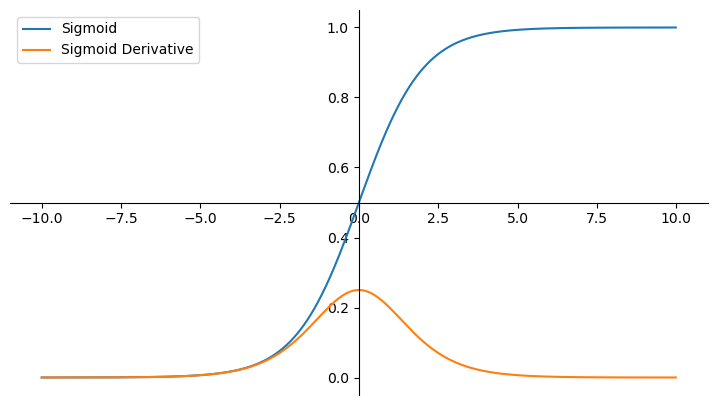

ReLU/Derivative


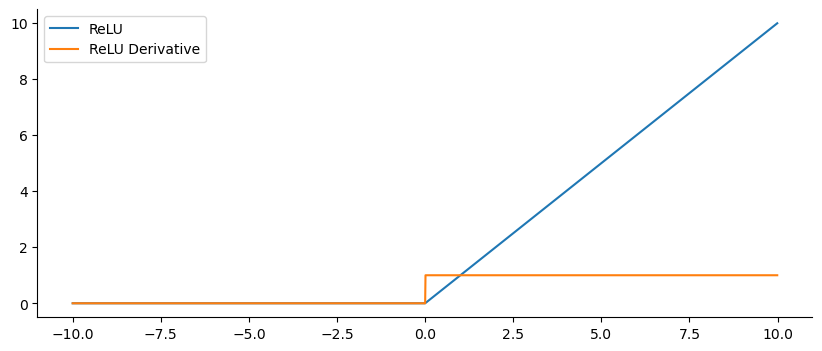

In [4]:
# Set range of input values for Sigmoid and ReLU
x = np.arange(-10, 10, 0.01)

# Generate Sigmoid/Derivative Plot
print("Sigmoid/Derivative\n")

fig1, ax1 = plt.subplots(figsize=(9, 5))

ax1.spines["left"].set_position("center")
ax1.spines["bottom"].set_position("center")
ax1.spines["top"].set_color("none")
ax1.spines["right"].set_color("none")

ax1.plot(x, sigmoid(x)[0], label = "Sigmoid")
ax1.plot(x, sigmoid(x)[1], label = "Sigmoid Derivative")
ax1.legend(loc = "upper left")
plt.show()

# Generate ReLU/Derivative Plot
print("ReLU/Derivative")

fig2, ax2 = plt.subplots(figsize = (10, 4))

ax2.spines["top"].set_color("none")
ax2.spines["right"].set_color("none")

ax2.plot(x, relu(x)[0], label = "ReLU")
ax2.plot(x, relu(x)[1], label = "ReLU Derivative")
ax2.legend(loc = "upper left")
plt.show()

In [5]:
# Presenting the difference between the two softmax functions

print(softmax([1,2000,-535])[0])
print(softmax_corrected([1,2000,-535])[0])

[ 0. nan  0.]
[0. 1. 0.]


### Set Random Seeds

In [6]:
# Random Seed and Seed Choice

randomer = 50
random.seed(randomer)
np.random.seed(randomer)

### Neural Network Class

In [7]:
# Neural Network Class

class NeuralNetwork:
    """
    Neural Network Class

    Parameters:
    - layer_sizes: A list containing first the input size, and lastly the output size. Hidden layers can optionally be added
      in between. For example [10, 128, 64, 2] for input of size 10, two hidden layers of size 128 and 64 respectively,
      and output of size 2.
    - activation_function: Activation function used in every layer.
    - dropout_rate: The probability of keeping a neuron inactive during dropout. A float between 0 and 1, where 0 means no dropout.
    - random_state: Seed used to generate the random weights. If no seed is specified, the seed set as 'randomer' will be used.
    """
    def __init__(self, layer_sizes, activation_function, dropout_rate = 0, random_state = randomer):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.activation_function = activation_function
        self.random_state = random_state
        self.parameters = self.initialise_parameters()
        self.dropout_rate = dropout_rate
        self.dropout_masks = None
    
    # Forward propagation
    def forward_propagation(self, X, is_training = True):
        # Store input values at layer and create dictionary for dropout (if used)
        cache = {"A0": X}
        self.dropout_masks = {}
        
        # Start from beginning of neural network
        for l in range(1, self.num_layers):
            # Get weights and bias at layer, and retrieve activation from previous layer
            Wl, bl = self.parameters[f"W{l}"], self.parameters[f"b{l}"]
            Al_prev = cache[f"A{l - 1}"]
            
            # Calculate weighted sum with bias at layer
            Zl = np.dot(Wl, Al_prev) + bl

            # Apply dropout during training
            if is_training and self.dropout_rate > 0:
                dropout_mask = (np.random.rand(*Zl.shape) < self.dropout_rate) / (1 - self.dropout_rate)
                self.dropout_masks[f"mask{l}"] = dropout_mask
                Zl *= dropout_mask
            
            # Apply transformation function to weighted sum
            Al = self.activation_function(Zl)[0]
            
            # Store weighted sum and activation
            cache[f"Z{l}"] = Zl
            cache[f"A{l}"] = Al

        return Al, cache
    
    # Backpropagation
    def backpropagation(self, A, Y, cache):
        m = Y.shape[1]
        # Create dictionary to store the gradients
        gradients = {}
        
        # Compute errors at layer
        dZ = A - Y
        # Start from end of neural network
        for l in reversed(range(1, self.num_layers)):
            # Get weights at layer, and retrieve activation from previous layer
            Al_prev = cache[f"A{l - 1}"]
            Wl = self.parameters[f"W{l}"]

            # Apply dropout during backpropagation
            if f"mask{l}" in self.dropout_masks:
                dZ *= self.dropout_masks[f"mask{l}"]
            
            # Add weight and bias gradients to dictionary
            gradients[f"dW{l}"] = np.dot(dZ, Al_prev.T) / m
            gradients[f"db{l}"] = np.sum(dZ, axis = 1, keepdims = True) / m
            
            # Compute derivative using activation function
            dZ = np.dot(Wl.T, dZ) * self.activation_function(Al_prev)[1]

        return gradients
        
    # Initialise weights
    def initialise_parameters(self):
        # Use random seed defined in the class parameters
        np.random.seed(self.random_state)
        # Create dictionary to store the weights
        parameters = {}
        # Go over each layer and create random weights
        for l in range(1, self.num_layers):
            # Normal distribution with mean 0 and standard deviation 0.01
            parameters[f"W{l}"] = np.random.randn(self.layer_sizes[l], self.layer_sizes[l - 1]) * 0.01
            parameters[f"b{l}"] = np.zeros((self.layer_sizes[l], 1))
        return parameters

    # Categorical cross-entropy loss function
    def compute_categorical_cross_entropy_loss(self, A, Y):
        m = Y.shape[1]
    
        # Clip probabilities to avoid log(0) issues
        epsilon = 1e-15
        A = np.clip(A, epsilon, 1 - epsilon)
    
        # Compute categorical cross-entropy loss
        loss = -np.sum(Y * np.log(A)) / m
    
        return loss
    
    # Accuracy function
    def compute_accuracy(self, A, Y):
        # Define the predicted labels
        predicted_labels = np.argmax(A, axis = 0)
        # Define the true labels
        true_labels = np.argmax(Y, axis = 0)
        return np.sum(predicted_labels == true_labels) / len(true_labels)
    
    # Update weights
    def update_parameters(self, gradients, learning_rate):
        # Gradient descent
        for l in range(1, self.num_layers):
            self.parameters[f"W{l}"] -= learning_rate * gradients[f"dW{l}"]
            self.parameters[f"b{l}"] -= learning_rate * gradients[f"db{l}"]
    
    # Function to train data, with epochs and learning rate as parameters
    def train(self, X, Y, num_epochs, learning_rate):
        # Save accuracy and losses to lists
        accuracies = []
        losses = []
        
        # Loop over every epoch
        for epoch in range(num_epochs):
            # Forward propagation
            A, cache = self.forward_propagation(X)
            
            # Compute loss
            loss = self.compute_categorical_cross_entropy_loss(A, Y)
            
            # Compute accuracy
            accuracy = self.compute_accuracy(A, Y)

            # Backpropagation
            gradients = self.backpropagation(A, Y, cache)

            # Update parameters
            self.update_parameters(gradients, learning_rate)
            
            # Output epoch number and loss value
            print(f"Epoch {epoch}, Accuracy: {round(accuracy * 100, 4)}%, Loss: {round(loss, 4)}")
            
            # Append accuracy and loss values to lists
            accuracies.append(accuracy)
            losses.append(loss)
        
        return accuracies, losses
    
    # Function for making predictions
    def predict(self, X):
        # Predict using forward propagation
        predictions, _ = self.forward_propagation(X, is_training = False)
        return predictions
    
    # Function to generate a confusion matrix
    def confusion_matrix(self, true_labels, predicted_labels):
        # Identify number of classes
        num_classes = len(np.unique(true_labels))
        # Create matrix of zeroes of size (num_classes * num_classes)
        cm = np.zeros((num_classes, num_classes), dtype = int)
        
        # Fill in the confusion matrix appropriately
        for true, predicted in zip(true_labels, predicted_labels):
            cm[true, predicted] += 1

        return cm
    
    # Function to plot confusion matrix from 'confusion_matrix'
    def plot_confusion_matrix(self, cm, classes):
        plt.imshow(cm, interpolation = "nearest", cmap = plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")

        # Add text annotations for each cell in the confusion matrix
        for i in range(len(classes)):
            for j in range(len(classes)):
                plt.text(j, i, str(cm[i, j]), ha = "center", va = "center", color = "white" if cm[i, j] > cm.max() / 2 else "black")

        plt.show()
    
    # Generate and plot confusion matrix from 'confusion_matrix' and 'plot_confusion_matrix', using the model
    def evaluate_confusion_matrix(self, X, Y, classes):
        # Make predictions of test set (or otherwise) using the model
        predictions = self.predict(X)
        # Define the predicted labels
        predicted_labels = np.argmax(predictions, axis = 0)
        # Define the true labels
        true_labels = np.argmax(Y, axis = 0)
        
        # Create and plot confusion matrix
        cm = self.confusion_matrix(true_labels, predicted_labels)
        self.plot_confusion_matrix(cm, classes = classes)

        return cm

### Hyperparameters

In [8]:
dropout_rate = 0
activation_function = relu
num_epochs = 300
learning_rate = 1
#optimiser = "sgd"

### Train Neural Network

In [9]:
# Define layer sizes (input, hidden, output)

input_size = X_train.shape[0]
output_size = y_train_one_hot.shape[0]
layer_sizes = [input_size, 64, output_size]

# Define model and train neural network on training set

model = NeuralNetwork(layer_sizes = layer_sizes, activation_function = activation_function, dropout_rate = dropout_rate, random_state = randomer)
history = model.train(X_train, y_train_one_hot, num_epochs = num_epochs, learning_rate = learning_rate)

Epoch 0, Accuracy: 13.0283%, Loss: 13.6716
Epoch 1, Accuracy: 31.5767%, Loss: 2.0166
Epoch 2, Accuracy: 55.53%, Loss: 2.3854
Epoch 3, Accuracy: 43.935%, Loss: 1.9395
Epoch 4, Accuracy: 59.9033%, Loss: 2.0067
Epoch 5, Accuracy: 45.02%, Loss: 1.6002
Epoch 6, Accuracy: 24.955%, Loss: 3.6087
Epoch 7, Accuracy: 26.9017%, Loss: 5.409
Epoch 8, Accuracy: 35.7217%, Loss: 9.2087
Epoch 9, Accuracy: 40.7033%, Loss: 3.48
Epoch 10, Accuracy: 46.6583%, Loss: 1.8086
Epoch 11, Accuracy: 32.9833%, Loss: 8.0558
Epoch 12, Accuracy: 40.2883%, Loss: 11.0904
Epoch 13, Accuracy: 36.2783%, Loss: 10.8775
Epoch 14, Accuracy: 55.1983%, Loss: 3.1581
Epoch 15, Accuracy: 45.94%, Loss: 2.907
Epoch 16, Accuracy: 38.73%, Loss: 11.5391
Epoch 17, Accuracy: 45.2733%, Loss: 12.8367
Epoch 18, Accuracy: 55.05%, Loss: 3.2224
Epoch 19, Accuracy: 60.3083%, Loss: 1.4217
Epoch 20, Accuracy: 69.055%, Loss: 1.261
Epoch 21, Accuracy: 58.62%, Loss: 2.4674
Epoch 22, Accuracy: 58.0417%, Loss: 3.4985
Epoch 23, Accuracy: 68.9067%, Loss: 

Epoch 192, Accuracy: 93.14%, Loss: 0.5375
Epoch 193, Accuracy: 93.27%, Loss: 0.5992
Epoch 194, Accuracy: 93.1717%, Loss: 0.5352
Epoch 195, Accuracy: 93.2817%, Loss: 0.5958
Epoch 196, Accuracy: 93.13%, Loss: 0.5348
Epoch 197, Accuracy: 93.265%, Loss: 0.5994
Epoch 198, Accuracy: 93.0783%, Loss: 0.54
Epoch 199, Accuracy: 93.2067%, Loss: 0.6017
Epoch 200, Accuracy: 93.0367%, Loss: 0.5473
Epoch 201, Accuracy: 93.1483%, Loss: 0.5965
Epoch 202, Accuracy: 93.015%, Loss: 0.5512
Epoch 203, Accuracy: 92.9267%, Loss: 0.6076
Epoch 204, Accuracy: 92.9367%, Loss: 0.5703
Epoch 205, Accuracy: 92.5633%, Loss: 0.6326
Epoch 206, Accuracy: 92.74%, Loss: 0.6085
Epoch 207, Accuracy: 92.2633%, Loss: 0.6424
Epoch 208, Accuracy: 92.84%, Loss: 0.6179
Epoch 209, Accuracy: 92.5217%, Loss: 0.6079
Epoch 210, Accuracy: 93.295%, Loss: 0.5853
Epoch 211, Accuracy: 92.905%, Loss: 0.5715
Epoch 212, Accuracy: 93.5533%, Loss: 0.5584
Epoch 213, Accuracy: 93.1683%, Loss: 0.5554
Epoch 214, Accuracy: 93.5733%, Loss: 0.5511
Epoc

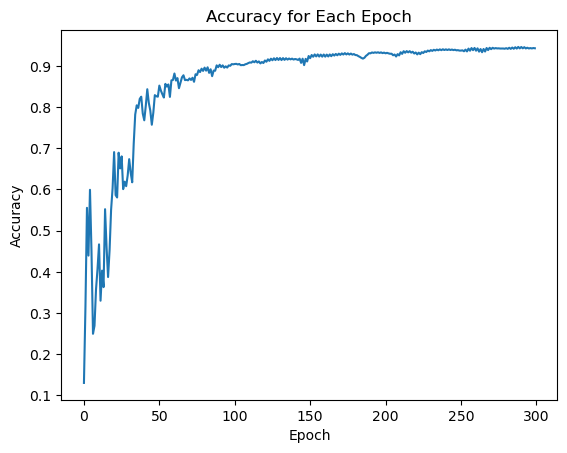

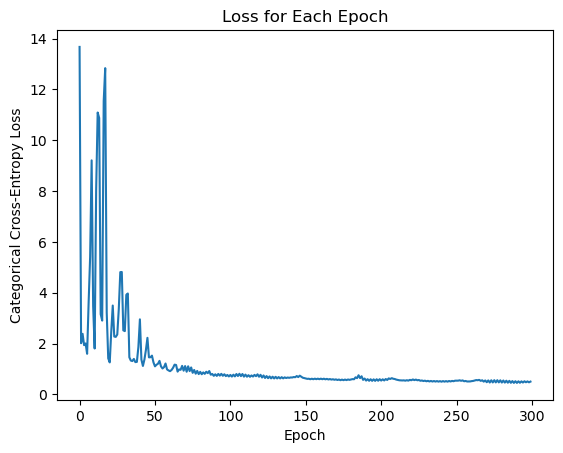

In [10]:
# Display accuracy per epoch

plt.plot(history[0])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy for Each Epoch")
plt.show()

# Display loss per epoch

plt.plot(history[1])
plt.xlabel("Epoch")
plt.ylabel("Categorical Cross-Entropy Loss")
plt.title("Loss for Each Epoch")
plt.show()

### Test Neural Network (Metrics)

In [11]:
# Test the neural network
predictions = model.predict(X_test)

# Calculate accuracy
accuracy = model.compute_accuracy(predictions, y_test_one_hot)
loss = model.compute_categorical_cross_entropy_loss(predictions, y_test_one_hot)

print(f"Accuracy: {round(accuracy, 4) * 100}%")
print(f"Loss: {round(loss, 4)}")

Accuracy: 94.61%
Loss: 0.4237


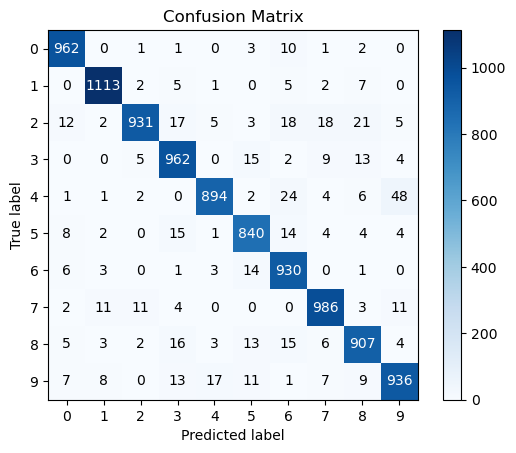

array([[ 962,    0,    1,    1,    0,    3,   10,    1,    2,    0],
       [   0, 1113,    2,    5,    1,    0,    5,    2,    7,    0],
       [  12,    2,  931,   17,    5,    3,   18,   18,   21,    5],
       [   0,    0,    5,  962,    0,   15,    2,    9,   13,    4],
       [   1,    1,    2,    0,  894,    2,   24,    4,    6,   48],
       [   8,    2,    0,   15,    1,  840,   14,    4,    4,    4],
       [   6,    3,    0,    1,    3,   14,  930,    0,    1,    0],
       [   2,   11,   11,    4,    0,    0,    0,  986,    3,   11],
       [   5,    3,    2,   16,    3,   13,   15,    6,  907,    4],
       [   7,    8,    0,   13,   17,   11,    1,    7,    9,  936]])

In [12]:
# Output confusion matrix

# 10 classes (as there are 10 digits)
class_names = [str(i) for i in range(10)]

# Call model and output confusion matrix
model.evaluate_confusion_matrix(X_test, y_test_one_hot, classes = class_names)